In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [2]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/distan_lat42.22lon-8.63p2R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [3]:
#@title Load station (Cloud level 1 height). Load meteorological model forecast D0.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LECO/input_files/LECOY2018Y2022.csv",
                          usecols =["time","skyl1_o"],
                          parse_dates=["time"]).dropna().set_index("time")
#clouds height meters to feet
num = pd.to_numeric(station.skyl1_o, errors="coerce")*3.28084

#label more or less than 200 feet
interval = pd.IntervalIndex.from_tuples([(-1, 500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,9000)])
labels = ["005","010","015","020","025","030","035","040","045","050"]


station["skyl1_l"] = pd.cut(num, bins=interval,retbins=False,labels=labels)
station["skyl1_l"] = station["skyl1_l"].map({a:b for a,b in zip(interval,labels)})
station["skyl1_l"] = station["skyl1_l"].astype(str).replace("nan","NClD")
station["skyl1_l"] = pd.Categorical(station["skyl1_l"])
print("\nCloud height frequencies")
display(station["skyl1_l"].value_counts(normalize=True).map(lambda n: '{:.1%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#Load


#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()






Cloud height frequencies


skyl1_l
NClD    32.4%
030     18.3%
025     10.6%
040      9.1%
015      7.8%
005      5.4%
020      4.7%
035      3.6%
010      3.4%
050      3.1%
045      1.6%
Name: proportion, dtype: object

In [4]:
num.describe()

count    60597.000000
mean      2410.269374
std       1171.820397
min          0.000000
25%       1601.049920
50%       2500.000080
75%       3198.819000
max       6000.656360
Name: skyl1_o, dtype: float64

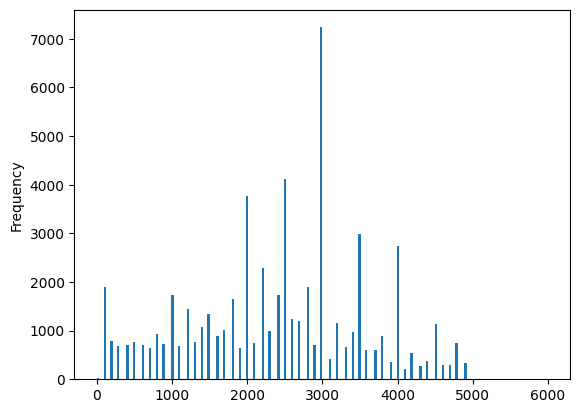

In [5]:
num.plot.hist(bins=200);

Round 0


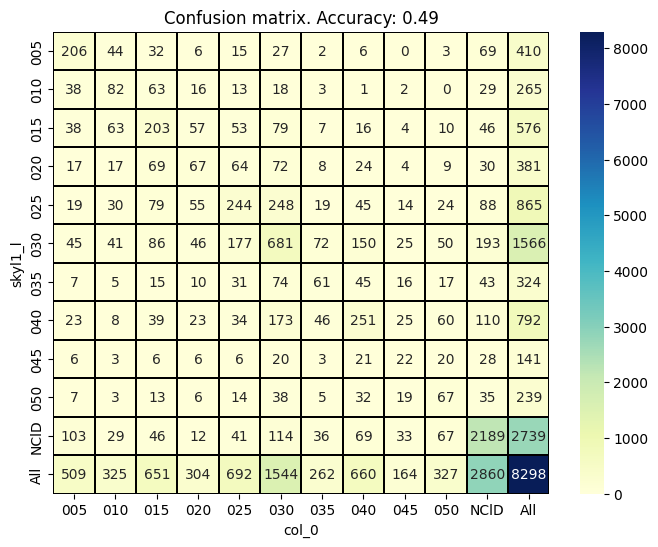

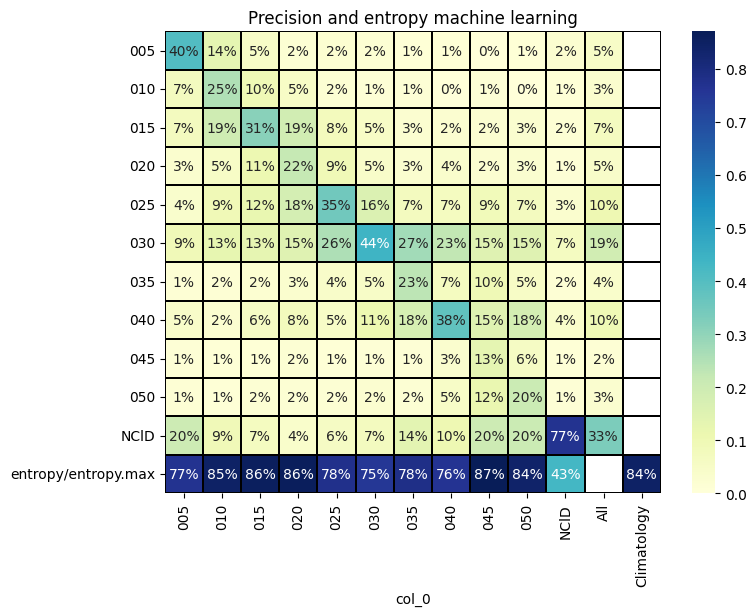

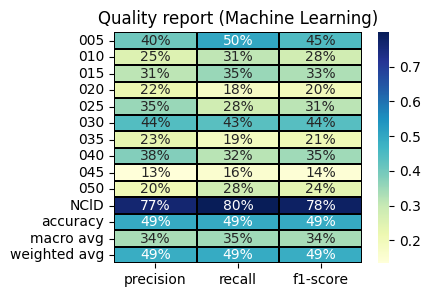

,feature,feature_per
52,dayofyear,4.3%
5,mslp0,3.7%
30,mslp1,3.2%
0,dir0,3.1%
2,snowlevel0,3.1%
25,dir1,3.0%
8,visibility0,2.9%
27,snowlevel1,2.9%
22,HGT8500,2.7%
24,T8500,2.7%


Round 1


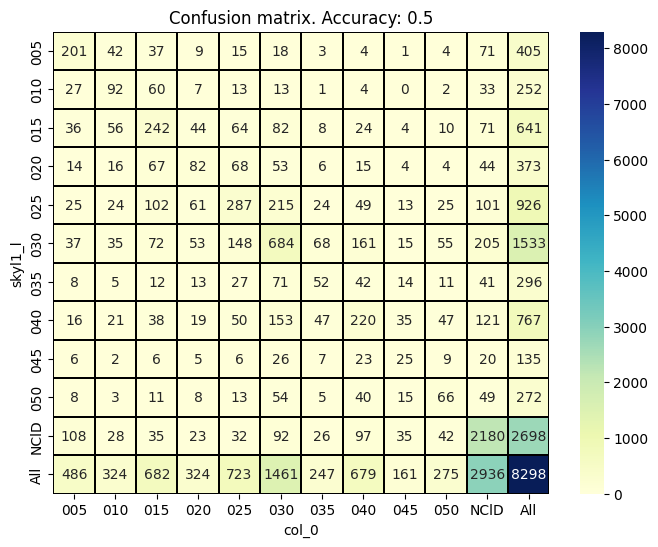

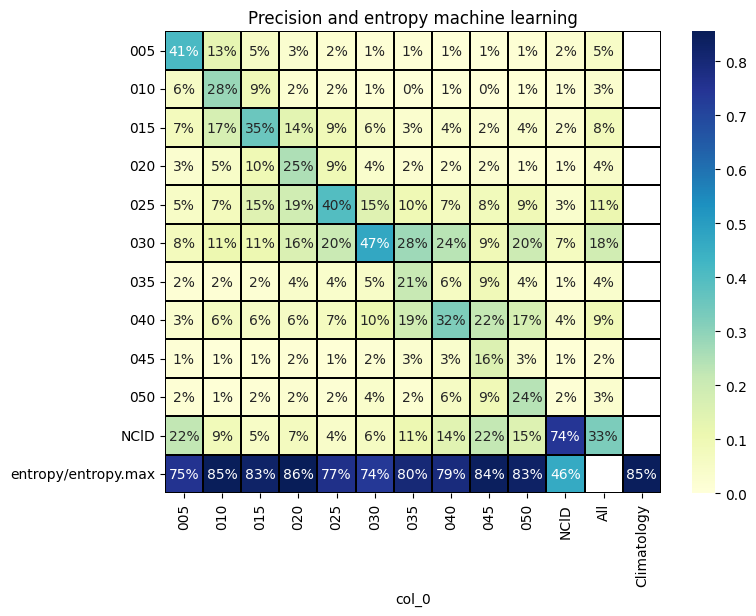

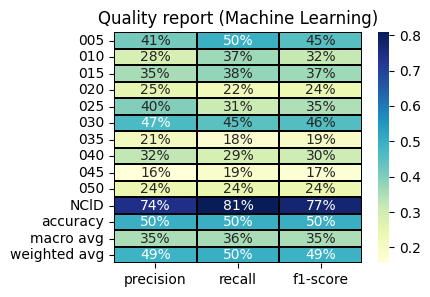

,feature,feature_per
52,dayofyear,4.1%
5,mslp0,3.7%
30,mslp1,3.2%
2,snowlevel0,3.1%
25,dir1,3.1%
0,dir0,3.0%
8,visibility0,2.9%
22,HGT8500,2.8%
27,snowlevel1,2.7%
50,hour,2.6%


Round 2


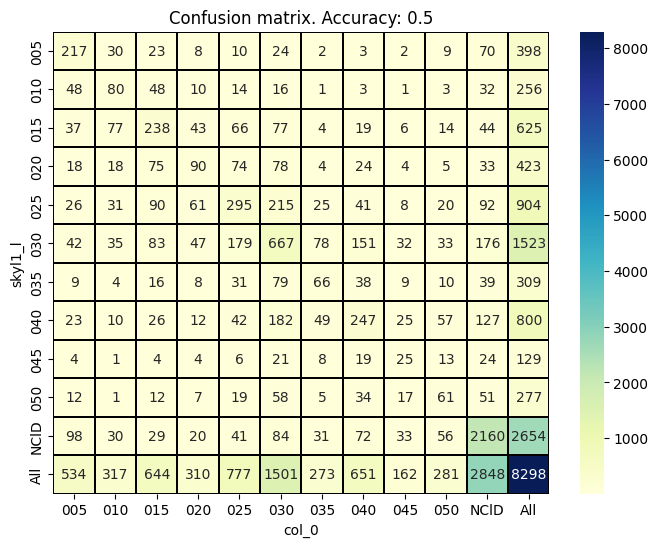

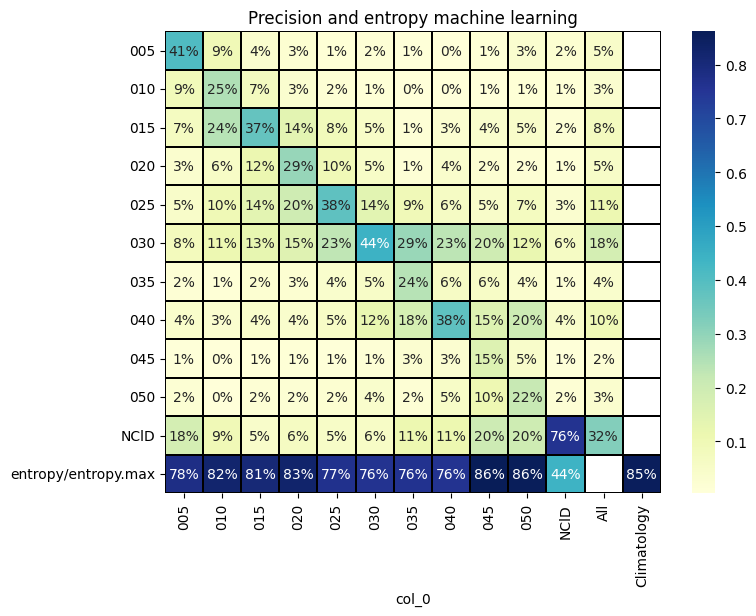

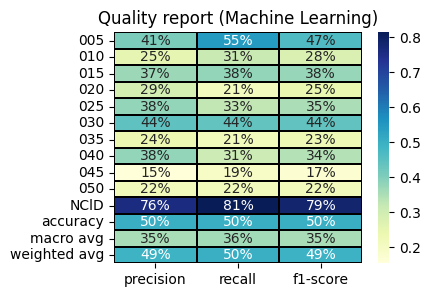

,feature,feature_per
52,dayofyear,4.2%
5,mslp0,3.6%
30,mslp1,3.2%
2,snowlevel0,3.2%
25,dir1,3.1%
0,dir0,3.0%
27,snowlevel1,2.8%
22,HGT8500,2.8%
8,visibility0,2.7%
50,hour,2.7%


Round 3


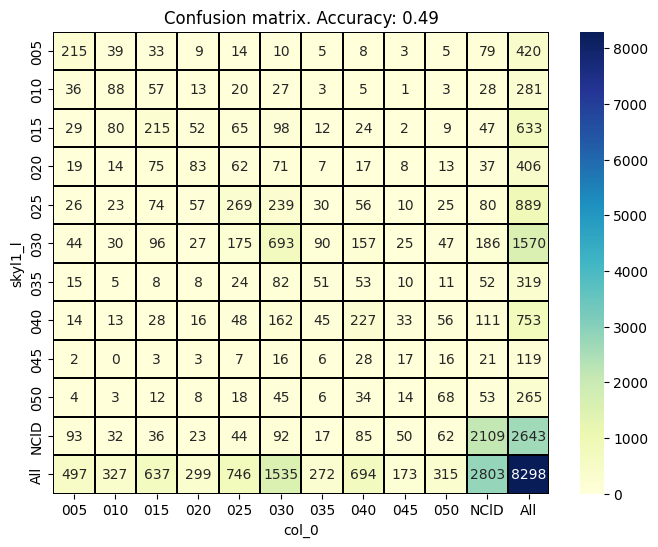

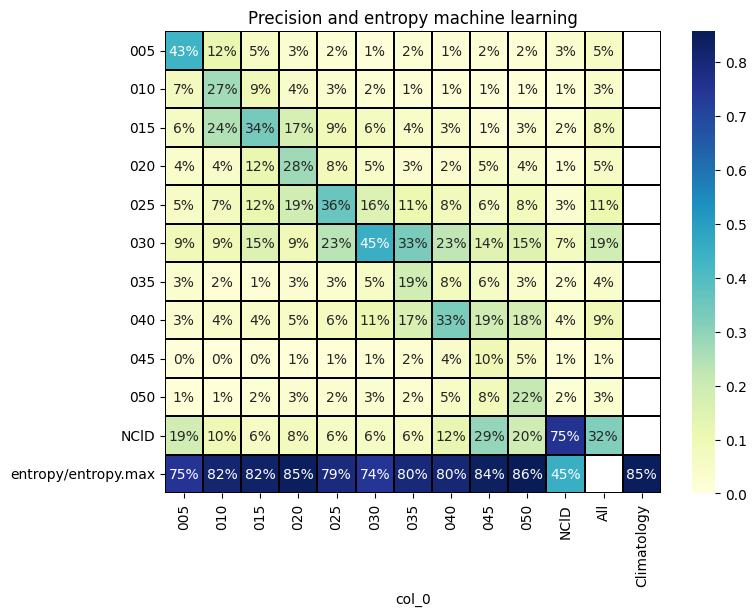

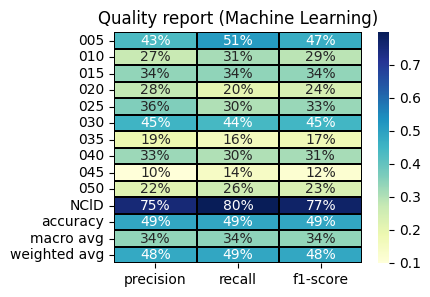

,feature,feature_per
52,dayofyear,4.3%
5,mslp0,3.6%
2,snowlevel0,3.2%
30,mslp1,3.2%
25,dir1,3.0%
0,dir0,2.9%
27,snowlevel1,2.9%
8,visibility0,2.9%
50,hour,2.6%
22,HGT8500,2.6%



Accuracy stadistics
       Accuracy
count  4.000000
mean   0.495000
std    0.005774
min    0.490000
25%    0.490000
50%    0.495000
75%    0.500000
max    0.500000
Shapiro test normality
p value: 0.02385682798922062
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 2.1220072898823216e-26
Significance level: 0.01
Degres of of freedom:  1
Stadistic 113.03311766185287
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 7.2 minutes


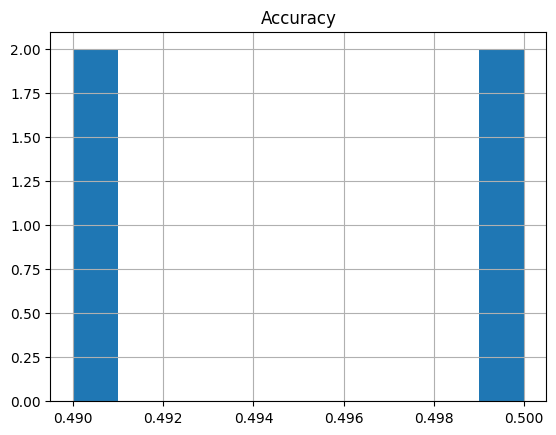

In [6]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,4):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [7]:
#@title Save last algorithm


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/llmskyl1_LEVX_d0.al", 'wb'))

Round 0


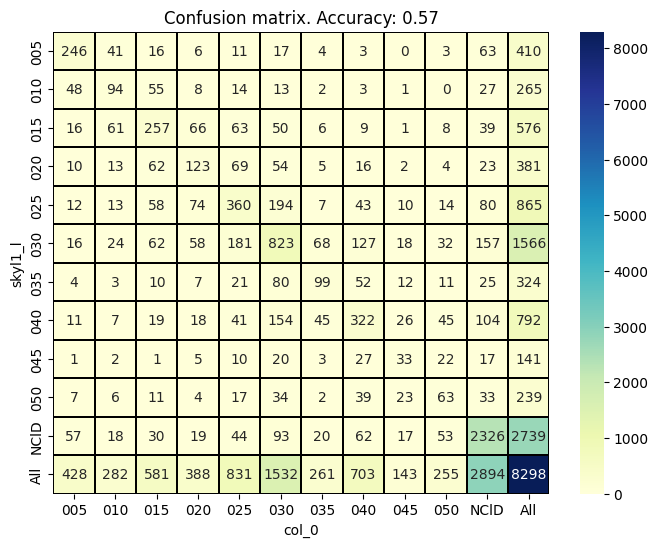

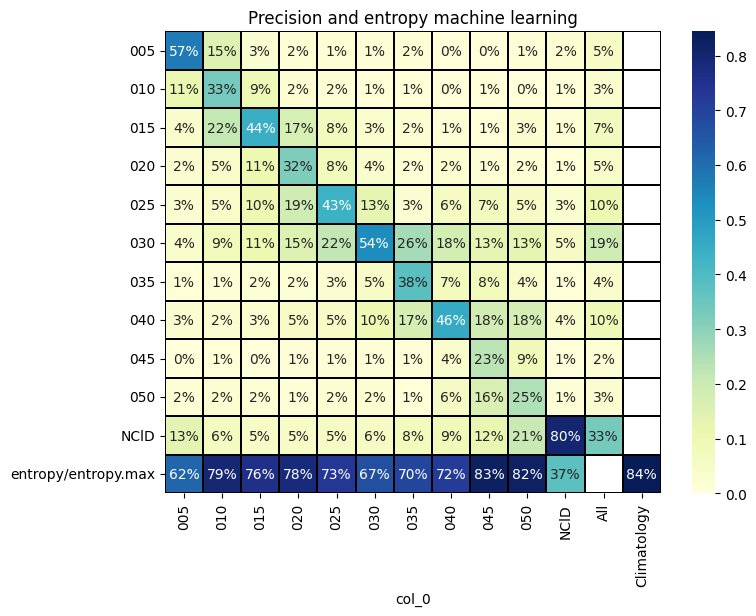

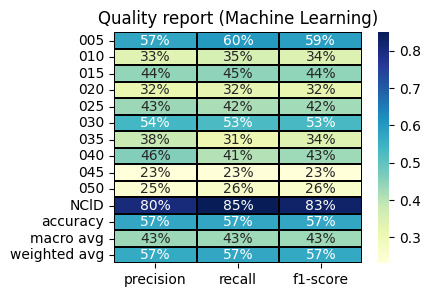

,feature,feature_per
2,snowlevel0,2.8%
27,snowlevel1,2.7%
5,mslp0,2.7%
30,mslp1,2.7%
24,T8500,2.6%
49,T8501,2.6%
47,HGT8501,2.6%
22,HGT8500,2.6%
50,hour,2.5%
52,dayofyear,2.5%


Round 1


KeyboardInterrupt: 

In [8]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]




# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")








In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/skyl1_LEST_d0.al", 'wb'))

Round 0


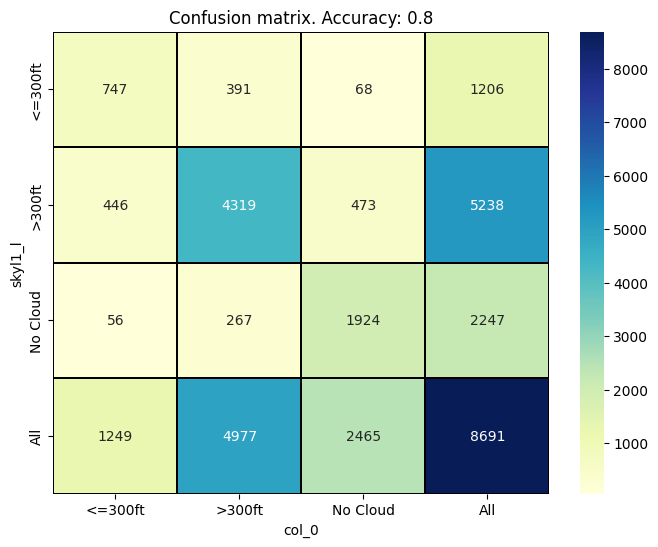

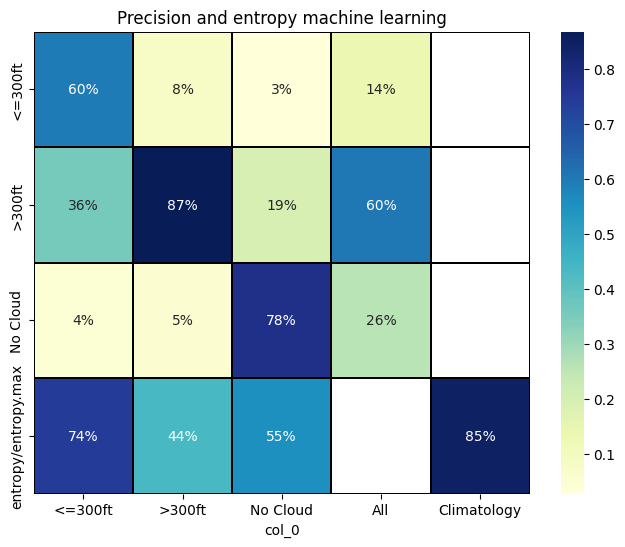

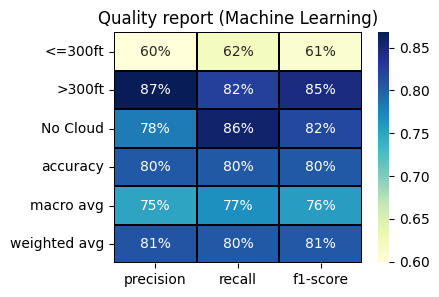

,feature,feature_per
102,dayofyear,4.4%
100,hour,2.8%
7,rh0,2.1%
39,shflx1,1.9%
25,dir1,1.7%
75,dir3,1.7%
64,shflx2,1.6%
50,dir2,1.5%
103,weekofyear,1.5%
49,T8501,1.5%


Round 1


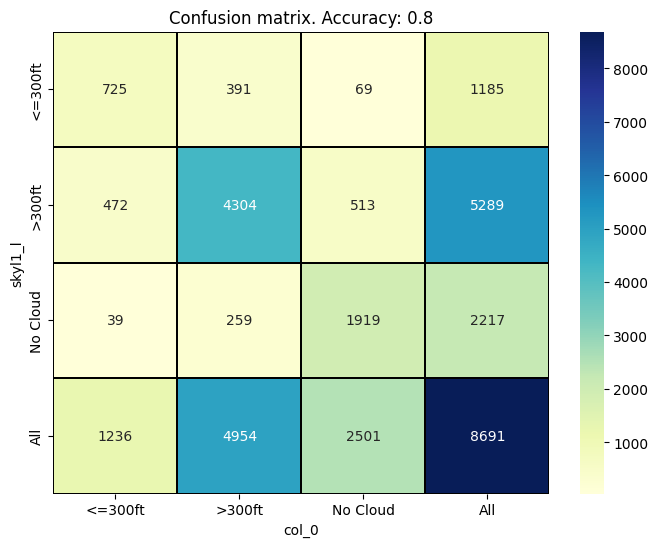

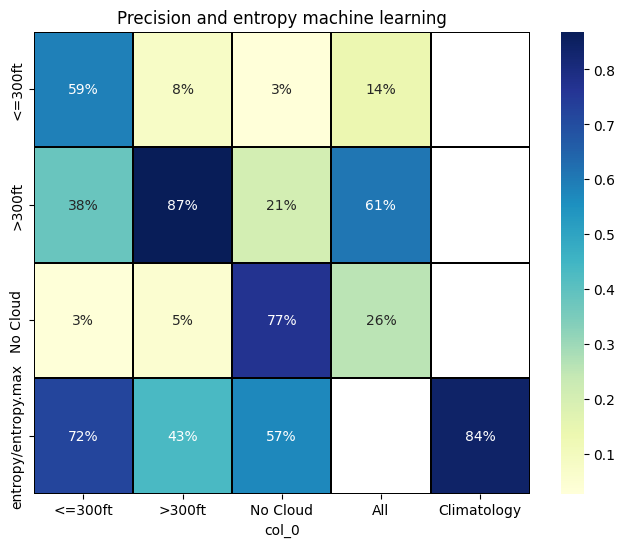

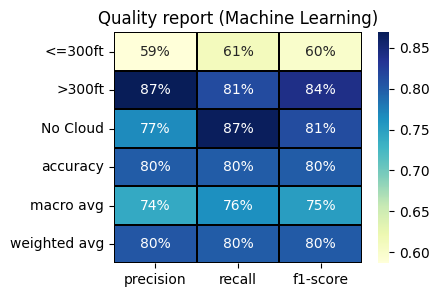

,feature,feature_per
102,dayofyear,4.5%
100,hour,2.4%
7,rh0,2.1%
39,shflx1,2.0%
0,dir0,1.6%
25,dir1,1.6%
101,month,1.6%
60,lwflx2,1.5%
75,dir3,1.5%
64,shflx2,1.5%


Round 2


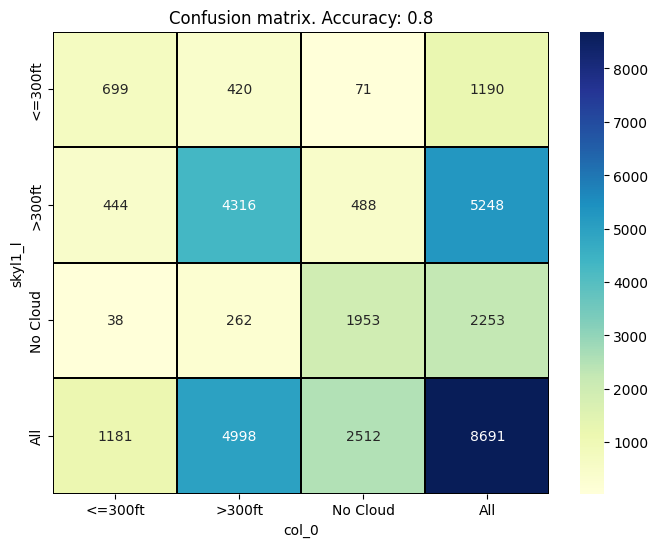

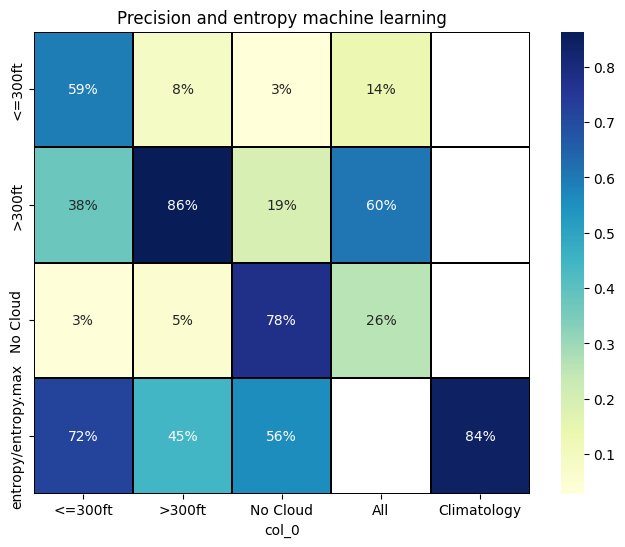

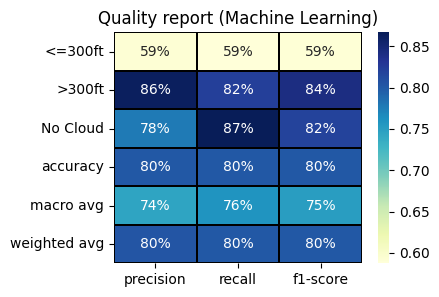

,feature,feature_per
102,dayofyear,4.0%
100,hour,2.5%
7,rh0,2.1%
75,dir3,1.8%
39,shflx1,1.7%
0,dir0,1.6%
25,dir1,1.5%
103,weekofyear,1.5%
60,lwflx2,1.5%
49,T8501,1.5%


Round 3


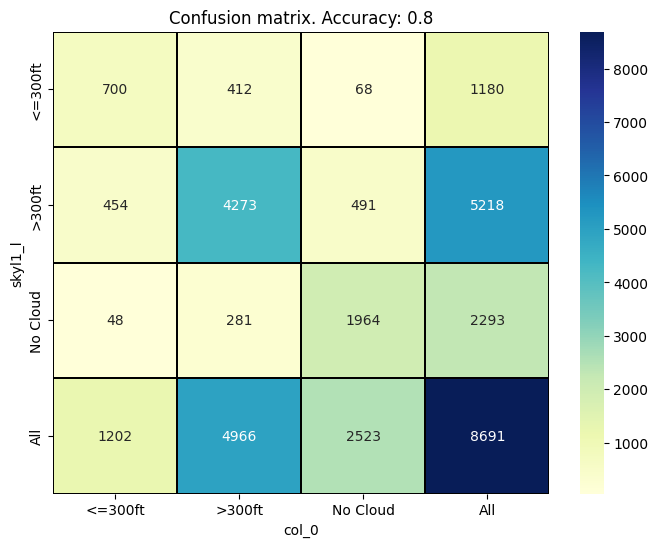

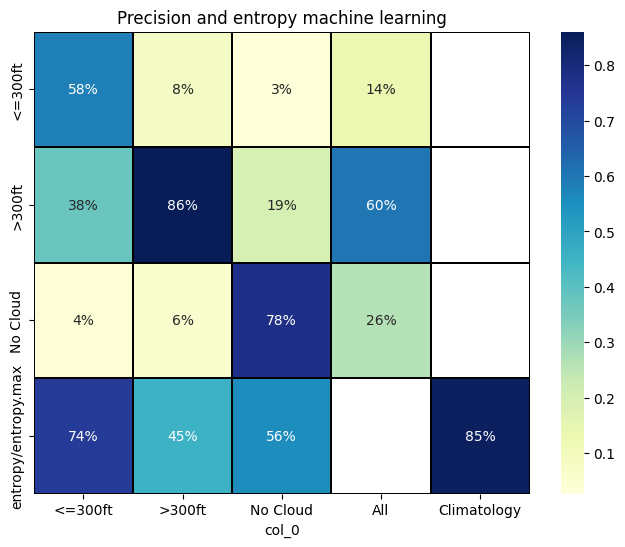

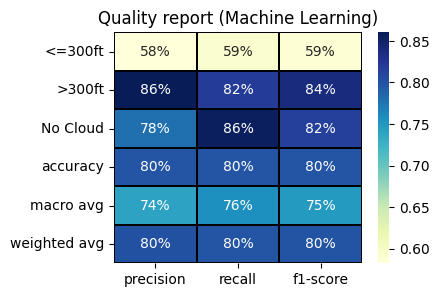

,feature,feature_per
102,dayofyear,4.6%
100,hour,2.6%
7,rh0,2.1%
39,shflx1,1.8%
75,dir3,1.7%
64,shflx2,1.6%
89,shflx3,1.6%
103,weekofyear,1.5%
60,lwflx2,1.5%
33,visibility1,1.5%


Round 4


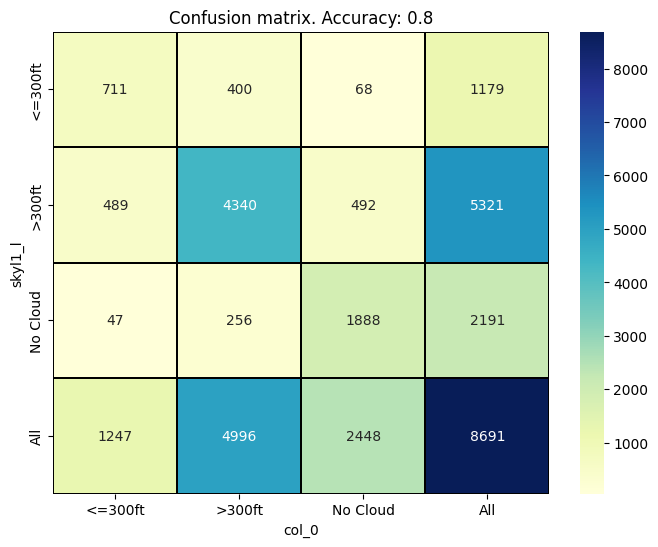

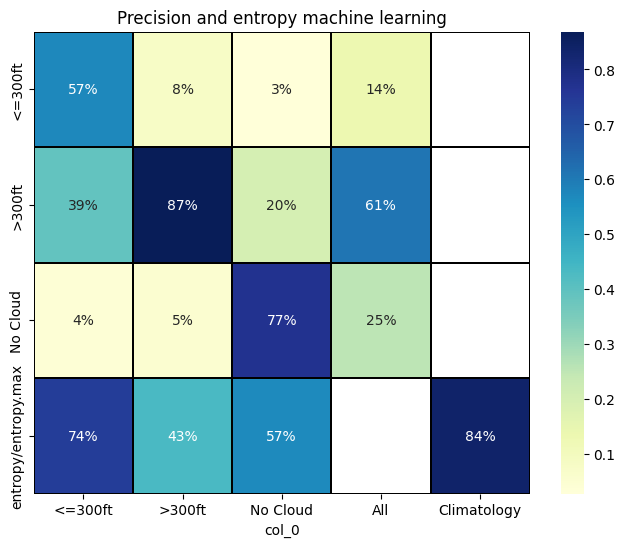

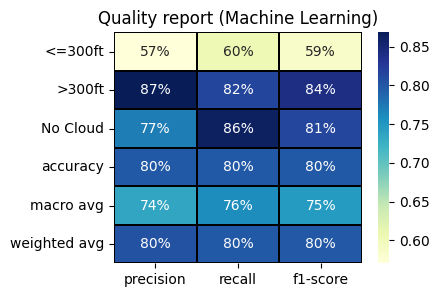

,feature,feature_per
102,dayofyear,4.4%
100,hour,2.4%
7,rh0,2.2%
39,shflx1,1.9%
25,dir1,1.7%
75,dir3,1.7%
64,shflx2,1.6%
54,wind_gust2,1.6%
101,month,1.5%
103,weekofyear,1.5%


Round 5


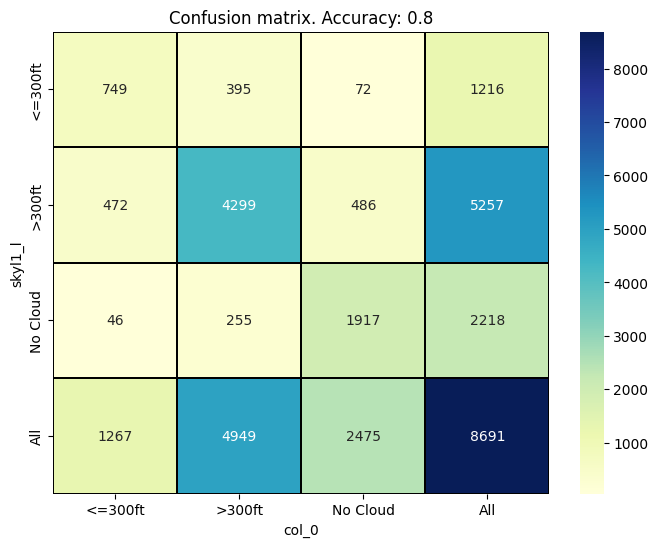

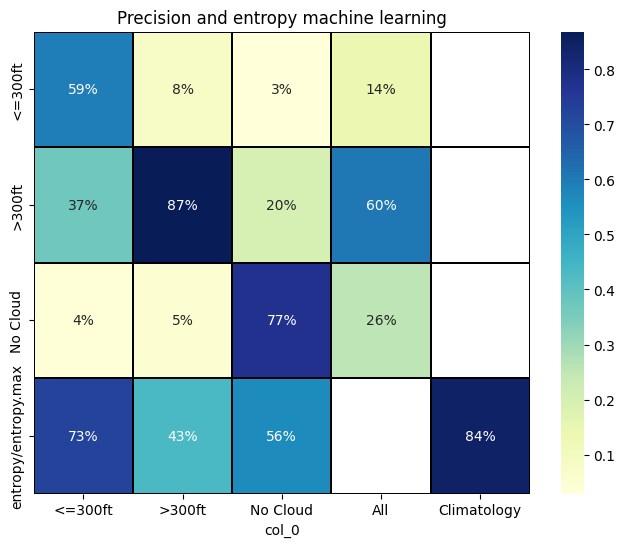

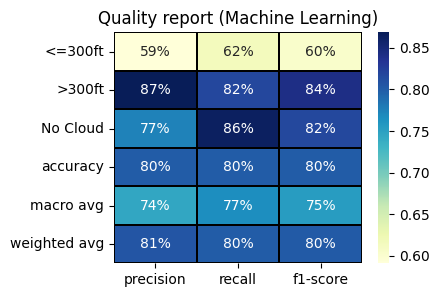

,feature,feature_per
102,dayofyear,4.4%
100,hour,2.8%
7,rh0,2.0%
39,shflx1,1.9%
75,dir3,1.5%
50,dir2,1.5%
60,lwflx2,1.5%
101,month,1.4%
89,shflx3,1.4%
64,shflx2,1.4%


Round 6


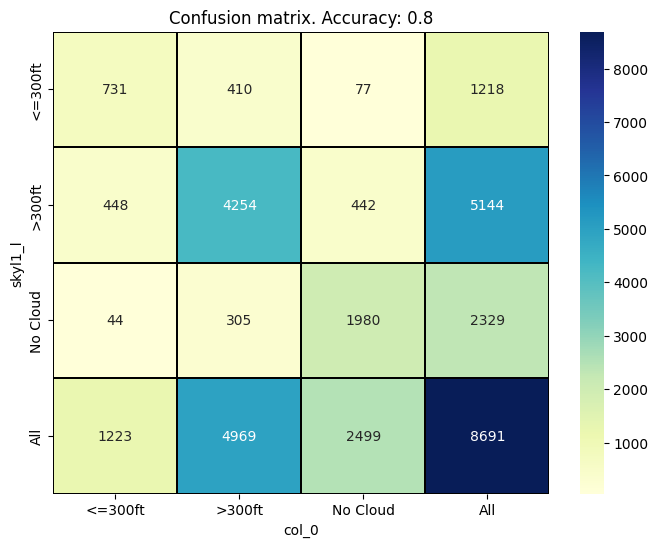

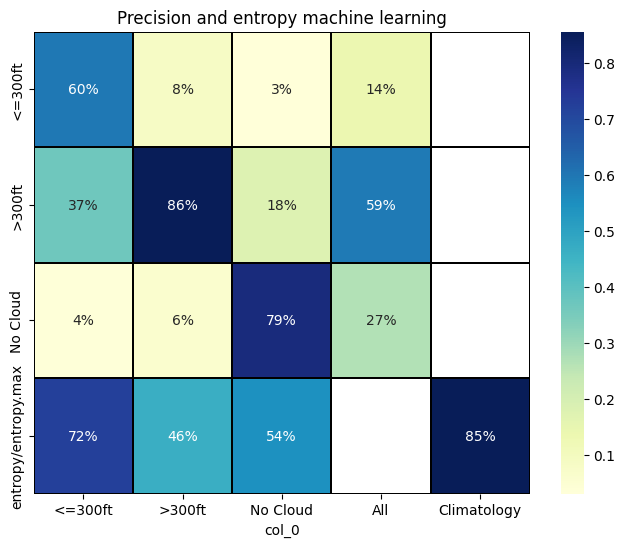

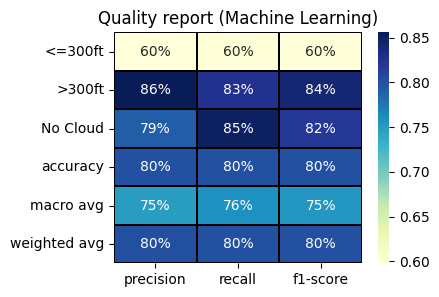

,feature,feature_per
102,dayofyear,4.1%
100,hour,2.6%
7,rh0,2.1%
39,shflx1,1.7%
25,dir1,1.6%
64,shflx2,1.5%
54,wind_gust2,1.5%
75,dir3,1.5%
50,dir2,1.5%
33,visibility1,1.5%


Round 7


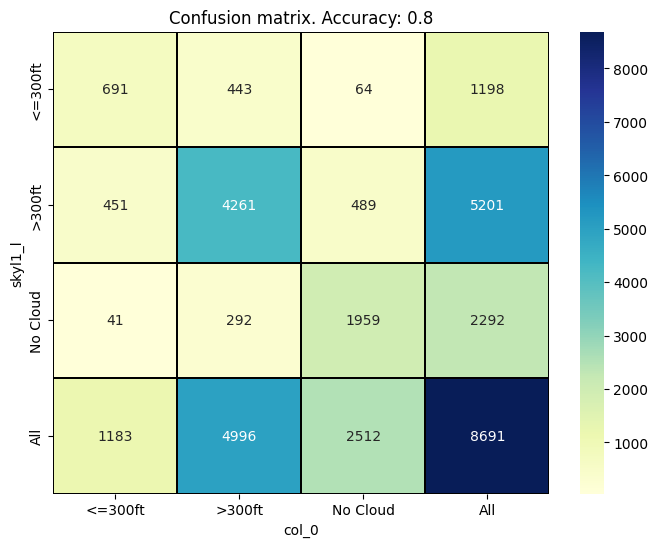

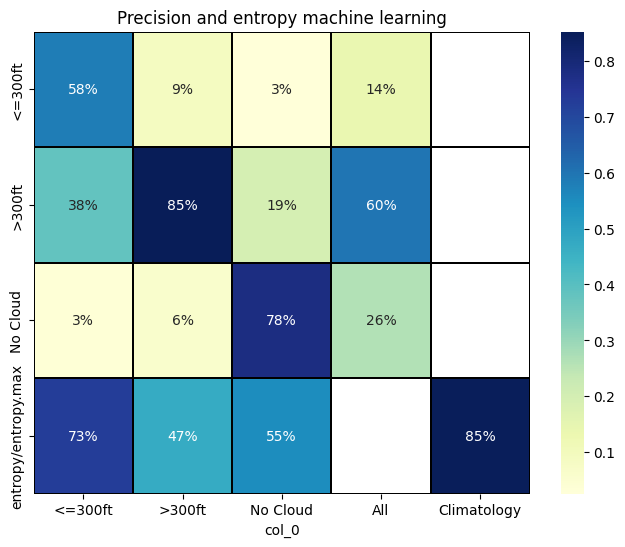

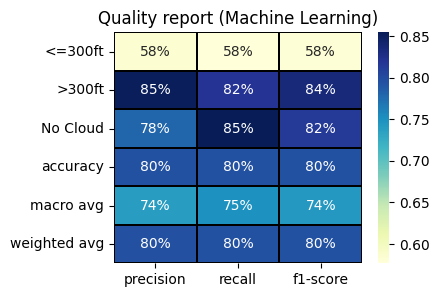

,feature,feature_per
102,dayofyear,4.3%
100,hour,2.6%
7,rh0,2.2%
39,shflx1,2.0%
25,dir1,1.6%
50,dir2,1.6%
64,shflx2,1.6%
54,wind_gust2,1.6%
75,dir3,1.6%
0,dir0,1.5%


Round 8


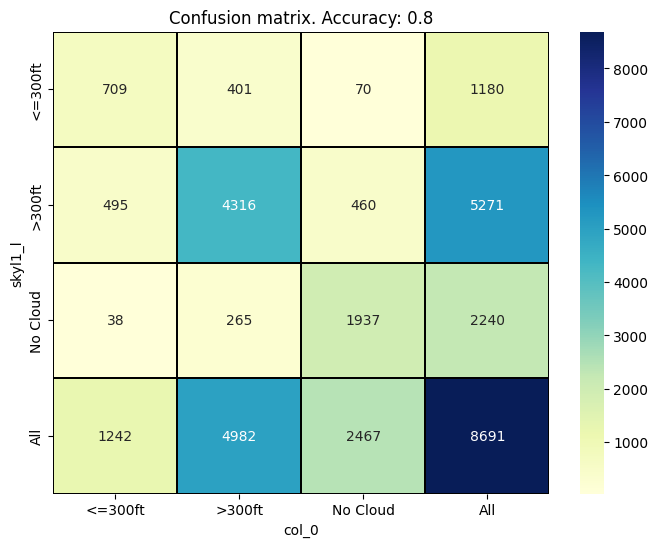

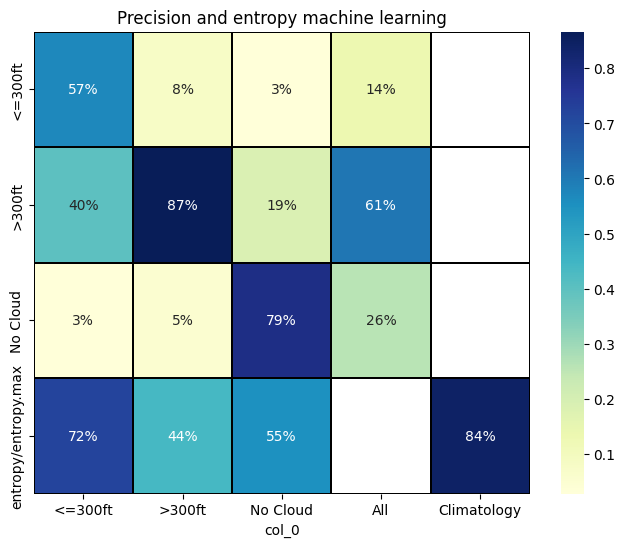

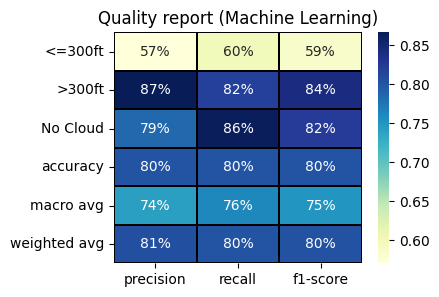

,feature,feature_per
102,dayofyear,4.1%
100,hour,2.5%
7,rh0,2.1%
39,shflx1,1.7%
75,dir3,1.6%
25,dir1,1.6%
64,shflx2,1.6%
60,lwflx2,1.6%
103,weekofyear,1.5%
74,T8502,1.4%


Round 9


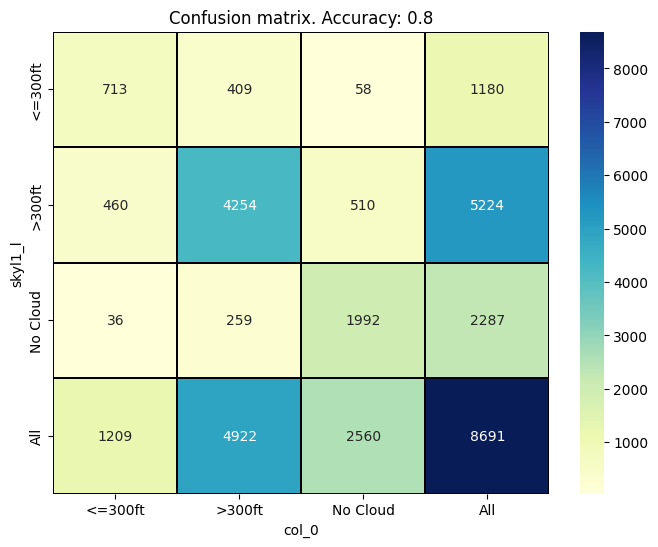

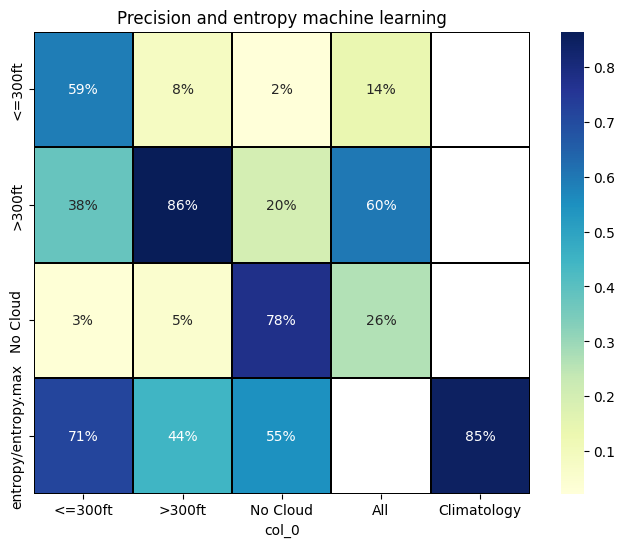

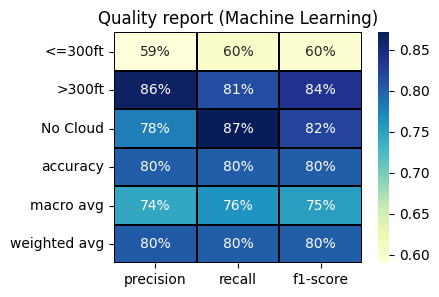

,feature,feature_per
102,dayofyear,4.5%
100,hour,2.4%
39,shflx1,2.2%
7,rh0,2.0%
25,dir1,1.7%
74,T8502,1.6%
64,shflx2,1.5%
60,lwflx2,1.5%
0,dir0,1.5%
75,dir3,1.5%



Accuracy stadistics
       Accuracy
count      10.0
mean        0.8
std         0.0
min         0.8
25%         0.8
50%         0.8
75%         0.8
max         0.8
Shapiro test normality
p value: 1.0
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1629.4123930583507
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 5.42 minutes


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1813: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



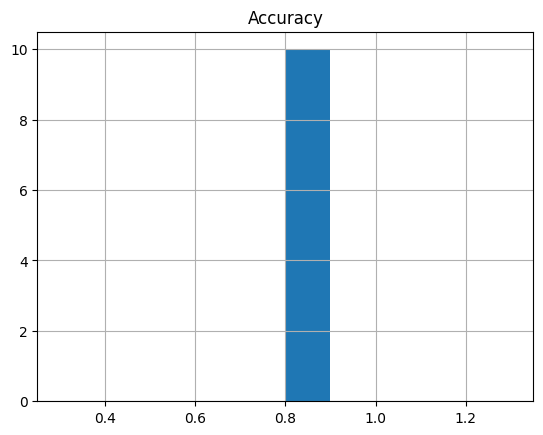

In [ ]:
#@title Load meteorological model forecast D1. ML LGBMClassifier. Samples 10. Heidke Skill score.
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")


In [ ]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/skyl1_LEST_d1.al", 'wb'))